# TODO

## NLP
- deal with english/italian mix
- deal with emojis
- better stopwords

## Network
- 

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import spacy
import glob
import re

from nltk.util import ngrams 

nlp = spacy.load('it_core_news_sm')

%matplotlib inline

In [42]:
# create data paths
_tweet_paths = glob.glob("./data/tweet_*")
_reply_paths = glob.glob("./data/replies_*")

# read in tweets and replies
# the objects tweets/replies are lists of pd.DataFrames with replies[i] being the first hundred replies of tweet[i]
tweets = [pd.read_csv(_path) for _path in _tweet_paths]
replies = [pd.read_csv(_path) for _path in _reply_paths]


print(f"Tweet by Meloni \n{tweets[0].text}\n")

print(f"First 5 replies \n{replies[0].head(5).text}")

Tweet by Meloni 
0    Buona festa dell’#ImmacolataConcezione a ciasc...
Name: text, dtype: object

First 5 replies 
0    @GiorgiaMeloni Sono convinto della tua buona f...
1    @GiorgiaMeloni The black flags that will suppo...
2    @GiorgiaMeloni "Bilateral relations" is the ke...
3    @GiorgiaMeloni 🟢🟢APPROVATE L'EMENDAMENTO 13.0....
4               @GiorgiaMeloni https://t.co/tcs15INIcM
Name: text, dtype: object


## Example spacy.nlp()

In [43]:
s = 'Io sto bene. Siamo volontieri #male, @meloni, @russia https://url.de'
doc = nlp(s)

print(f"Token\t\tLemma\t\tUrl\tStopword")
print("="*40)
for token in doc:
    print(f"{token}\t\t{token.lemma_}\t\t{token.like_url}\t{token.is_stop}")

Token		Lemma		Url	Stopword
Io		io		False	True
sto		stare		False	True
bene		bene		False	True
.		.		False	False
Siamo		essere		False	True
volontieri		volontiero		False	False
#		#		False	False
male		male		False	True
,		,		False	False
@meloni		@melone		False	False
,		,		False	False
@russia		@russia		False	False
https://url.de		Https://url.de		True	False


## Tokenize and clean Tweets

In [44]:
def clean_text(text, search_words):
    doc = nlp(text)

    bog = []

    for token in doc:

        # filter stopwords
        if not token.is_stop:
            # filter punctiation
            if not token.is_punct:
                if not token.like_url:
                    if not token.like_email:
                        if not token.is_space:
                            if token.lemma_ not in ['\n', ' ']:
                                # filter words used to search for tweets            
                                if str(token) not in search_words:
                                    bog.append(re.sub('@', '', token.lemma_))
                                
    
    return bog

        

In [46]:
# select an example to work on
df = replies[0]
df.head(2)

,Unnamed: 0,edit_history_tweet_ids,id,text
0,0,['1601278050687012864'],1601278050687012864,@GiorgiaMeloni Sono convinto della tua buona f...
1,1,['1601107298424066048'],1601107298424066048,@GiorgiaMeloni The black flags that will suppo...


In [47]:
# word that were part of the search (or highly related to it) should be filtered out
search_words = ['@GiorgiaMeloni', '@Palazzo_Chigi', '@CheikhGhazouani']

# tokenize and clean tweets
df['bog'] = df.text.apply(lambda x: clean_text(x, search_words))

# create bigrams that can be used as edges for a linguistic network
df['bigrams'] = df.bog.apply(lambda x: list(ngrams(x, 2)))

       word  count
0         😂     60
1       the     17
2        il     15
3    Meloni      8
4   Giorgia      8
5         x      7
6        to      7
7  italiano      6
8        of      6
9        is      6


/home/jan/ds/3rd-semester/NetSci/netsci-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jan/ds/3rd-semester/NetSci/netsci-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128075 (\N{WAVING HAND SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jan/ds/3rd-semester/NetSci/netsci-venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


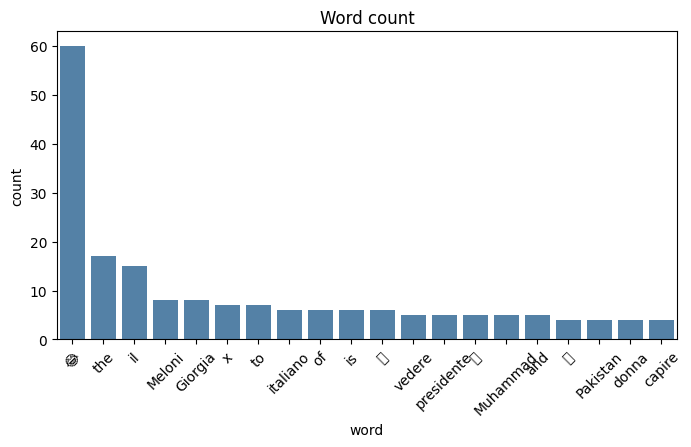

In [48]:
word_count = df.bog.explode().value_counts().reset_index().rename(columns={'index':'word', 'bog':'count'}).head(20)

# # top 10 degrees
print(word_count.head(10))

# plot distribution of degrees
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=word_count['word'], y=word_count['count'], ax=ax, color='steelblue')
ax.set_title('Word count')
ax.tick_params(axis='x', labelrotation = 45)
plt.show()

## Linguistic network

In [49]:
# create edgelist from bigrams
edgelist = []
for edges in df.bigrams:
    edgelist = edgelist + edges

print(f'Number of edges: \t\t {len(edgelist)}')

# remove duplicates
edgelist = list(set(edgelist))

print(f'Number of unique edges: \t {len(edgelist)}')

Number of edges: 		 899
Number of unique edges: 	 813


In [50]:
# create graph from edgelist
G = nx.Graph()
G.add_edges_from(edgelist)

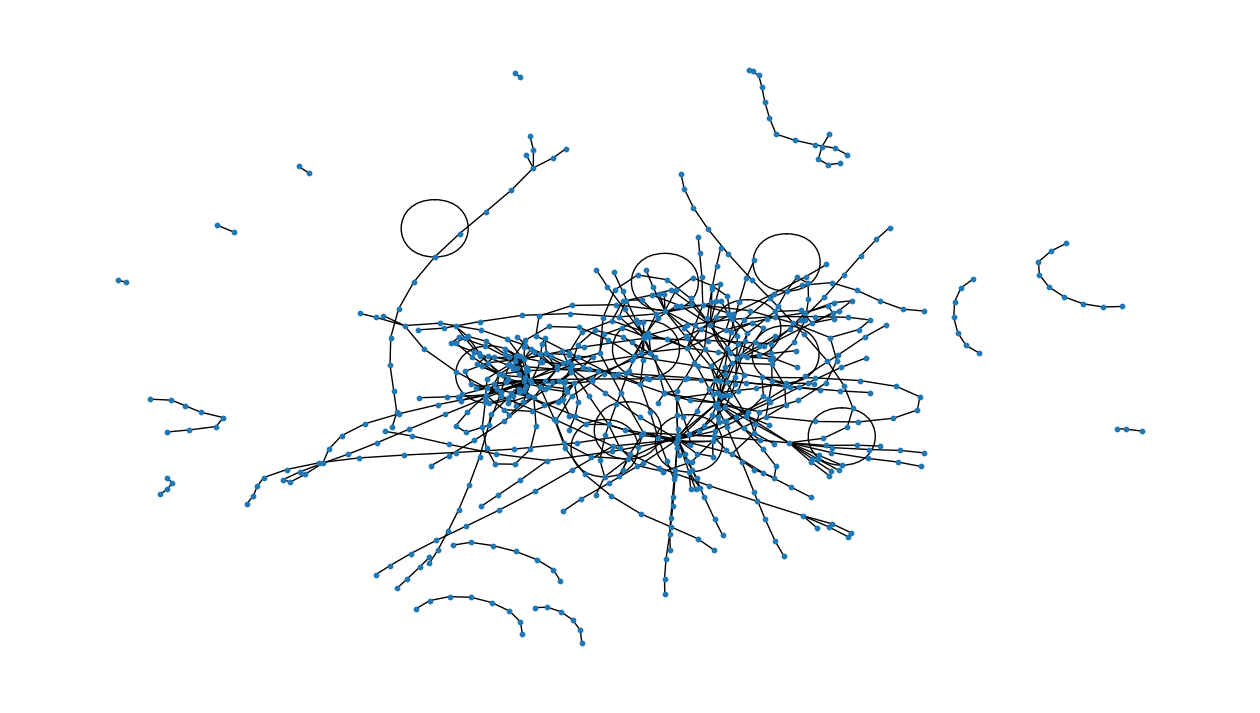

In [51]:
my_pos = nx.spring_layout(G, seed = 100)
fig, ax = plt.subplots(figsize=(16, 9))

nx.draw(G, node_size=10, pos=my_pos, ax=ax)

### Degree centrality

In [21]:
dc_raw = nx.degree_centrality(G)
dc = pd.DataFrame([(key, value) for key, value in dc_raw.items()], columns=['node', 'dc'])

In [22]:
dc.sort_values('dc', ascending=False).head(10)

,node,dc
10,the,0.039244
61,il,0.037791
214,x,0.020349
73,to,0.017442
119,of,0.017442
88,Meloni,0.015988
270,is,0.015988
42,italiano,0.014535
45,vedere,0.014535
57,😂,0.014535
